# Nondeterministic Actions: Solving Tic-Tac-Toe with AND-OR-Tree Search

## Introduction 
 
Multiplayer games can be implemented as:
1. __Nondeterministic actions:__ The opponent is seen as part of an environment with nondeterministic actions. Non-determinism is the result of the unknown opponent's moves. 
2. Optimal Decisions: Minimax search (search complete game tree) and alpha-beta pruning.
3. Heuristic Alpha-Beta Tree Search: Cut off tree search and use heuristic to estimate state value. 
4. Monte Carlo Tree search: Simulate playouts to estimate state value. 

Here we will implement search for Tic-Tac-Toe (see [rules](https://en.wikipedia.org/wiki/Tic-tac-toe)).

We will implement
* __AND-OR-Tree search.__

Each action consists of the move by the player (OR levels in the tree) and all possible (i.e., nondeterministic) responses by the opponents (AND levels). The action therefore results in a set of possible states.

We will search for a __conditional plan__ using AND-OR-Tree search. 

## The Search Problem

* **Initial State:** Empty $3 \times 3$ board. It is the move for $x$.
* **Actions:** Place your symbol on any empty square.
* **Transition function:** You symbol is placed on the board according to the action. The opponent
    places her symbol. From our viewpoint this makes the environment non-deterministic.
* **Goal state:** A win (three symbols in a row, column or diagonal). 
* **Path cost:** number of moves.
  

**Notes:**

* Since this is a game, we will see that instead of the goal state we will use a test for a **terminal state** (game is over) and a **utility function** (win or loose). 

* We will use DFS which is not optimal. So will probably not find the solution with the lowest path cost, i.e., win with the smallest number of moves.

## State Space and Search Tree Size

Each state is a possible board. Each of the 9 squares can have 3 values (empty, x and o), but some boards are impossible (where a player has several sequences of 3).The number of states in the state space graph is less than:

In [1]:
3**9

19683

A search tree is a subgraph with all cycles removed. The standard implementation of DFS cannot remove redundant paths (i.e., getting to the same board by plcing symbols in a different order). Therefore, a state can be represented by several nodes in different branches! We observe the following:

* The complete search tree has a maximal depth $m=9$
* The max branching factor $b=9$ (for first move).

DFS has

* a space complexity of $O(bm)$ (current path plus frontier) and 
* a time complecity of $O(b^m)$ (number of expanded nodes).

In [2]:
# Space Complexity O(bm):
9*9

81

In [3]:
# Time Complexity O(b^m): 
9**9

387420489

However, the branching factor decreases after each move. The first level has a branching factor of 9, the second a branching factor of 8, etc. The total number of nodes is:

| Level     |  # of nodes       |
| :-------- | :---------------- |
| root       | $1$ |
| level 1    | $9$ |
| level 2    | $9 \times 8$ |
| level 2    | $9 \times 8 \times 7$ |
| ...        |  ... |
| level 9    | $9 \times 8 \times \dots \times 2 \times 1 = 9!$ |

The total number of game tree nodes is less (some games end early) than the sum of the nodes above. The upper bound for the number of nodes is:

In [4]:
sum = 0
fac = 1
print("level\t# nodes")
print("root\t 1")

for i in range(9, 0, -1):
    fac *= i
    sum += fac 
    print(10-i, "\t",fac)
    
    
sum

level	# nodes
root	 1
1 	 9
2 	 72
3 	 504
4 	 3024
5 	 15120
6 	 60480
7 	 181440
8 	 362880
9 	 362880


986409

Since some sequences are cut short because of a win, we expect fewer nodes in the game complete tree.

__Note:__ This size makes tic-tac-toe a very small problem that can be easily solved by tree search. Most games and real problems are too large and cannot be solved this way. For example, chess has an estmiated state space size of $>10^{30}$. 
We will learn several methods that address this problem later.

## The board

I represent the board as a vector of length 9. The values are `' ', 'x', 'o'`.  

In [5]:
def empty_board():
    return [' '] * 9

board = empty_board()
board[0] = 'x'; board[3] = 'o'; board[6] = 'x';  
display(board)

['x', ' ', ' ', 'o', ' ', ' ', 'x', ' ', ' ']

### Helper functions

Show the board.

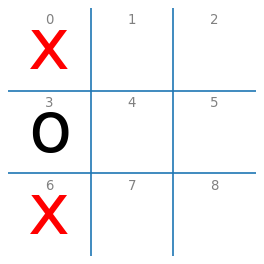

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# use higher resolution images in notebook

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


def show_board(board, help = True, dpi = 40, colors = {' ': 'white', 'x': 'red', 'o': 'black'}):
    """Show the tic-tac-toe-board. help adds the array index, dpi changes the sice and 
    colors sets the colors"""
    
    b = np.array(board).reshape((3,3))

    with plt.rc_context({'figure.dpi': dpi}):
        fig = plt.matshow(np.zeros((3, 3)), cmap = ListedColormap(['w']))
    fig.axes.axis('off')
    
    plt.hlines([.5, 1.5], -.5, 2.5)
    plt.vlines([.5, 1.5], -.5, 2.5)

    for row in range(3):
        for col in range(3):
            plt.text(row, col, b[col, row], 
                 fontsize = 64, 
                 color = colors[b[col, row]],
                 horizontalalignment = 'center',
                 verticalalignment = 'center')
        
    if help:
        for row in range(3):
            for col in range(3):
                plt.text(col, row - .35, col + 3 * row, 
                     fontsize = 12, 
                     color = 'gray',
                     horizontalalignment = 'center',
                     verticalalignment = 'center')
        
        
    plt.show()
    
show_board(board)

Determine if the current board/state has a winner.

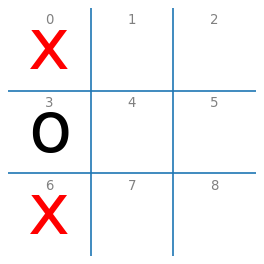

Win? n



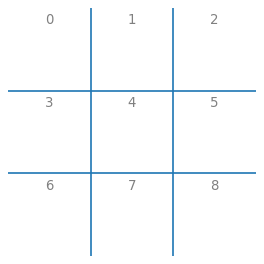

Win? n


In [7]:
def check_win(board):
    """check the board and return one of x, o, d (draw), or n (for next move)"""

    board = np.array(board).reshape((3,3))
   
    diagonals = np.array([[board[i][i] for i in range(len(board))], 
                          [board[i][len(board)-i-1] for i in range(len(board))]])
    
    for a_board in [board, np.transpose(board), diagonals]:
        for row in a_board:
            if len(set(row)) == 1 and row[0] != ' ':
                return row[0]

    # check for draw
    if(np.sum(board == ' ') < 1):
        return 'd'
    
    return 'n'

show_board(board)
print('Win? ' + check_win(board))

print()
show_board(empty_board())
print('Win? ' + check_win(empty_board()))

What are the possible actions given the current board?

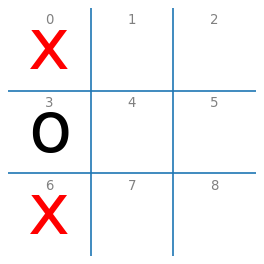

[1, 2, 4, 5, 7, 8]

In [8]:
def actions(board):
    """return possible actions as a vector of indices"""
    return np.where(np.array(board) == ' ')[0].tolist()

show_board(board)
actions(board)

What is the new state after executing an action. 

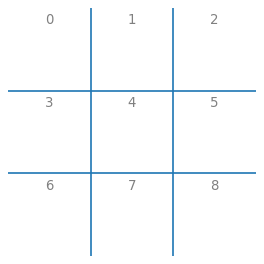


New state after placing an x at position 4:


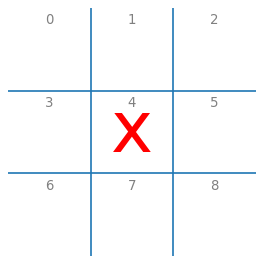

In [9]:
def result(state, player, action):
    """Add move to the board."""
    
    if(state[action] != ' '):
        print("Error: Illegal move!")
        
    state = state.copy()
    state[action] = player
  
    return state

show_board(empty_board())

print()
print("New state after placing an x at position 4:")
show_board(result(empty_board(), 'x', 4))

## Solving Tic-Tac-Toe using AND-OR-Tree Search

See AIMA page 125. 

Modifications to the algorithm in the textbook:
* Since the opponent and her moves are part of the environment, I modify the `results()` function to return for a state $\times$ action combination a set of new states that reflects all possible responses by the opponent.
* I have removed tracking the path since it is not used for the game.
* I do not perform cycle checking (not needed for this game).
* Goal: 
    - End search (prune subtree) when player loses. 
    - Check for loss also in the "AND" phase.
    - Draw can be set as a goal state or a loss. Since DSF finds the first solution, it might be a draw while there is still a solution where the player could win. Considering draw a loss will prune the "draw" solutions and leave only the "wins," if any.


### Non-deterministic Results

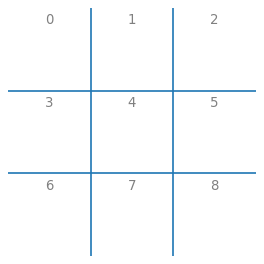


Set of possible state for placing an x at position 4 of an empty board and the opponent's move:


[['o', ' ', ' ', ' ', 'x', ' ', ' ', ' ', ' '],
 [' ', 'o', ' ', ' ', 'x', ' ', ' ', ' ', ' '],
 [' ', ' ', 'o', ' ', 'x', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', 'o', 'x', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', 'x', 'o', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', 'x', ' ', 'o', ' ', ' '],
 [' ', ' ', ' ', ' ', 'x', ' ', ' ', 'o', ' '],
 [' ', ' ', ' ', ' ', 'x', ' ', ' ', ' ', 'o']]

In [10]:
def results(state, action, player = 'x'):
    """produce the set of states after the provided action for player. 
       It is the set of boards with the action and all possible reactions by the opponent."""
    
    if player == 'x': other = 'o'
    else: other = 'x'
    
    state = state.copy()
    
    # player's move
    state[action] = player
    
    # opponent reacts
    r = list()
    o_actions = actions(state)
    
    # board is full
    if len(o_actions) < 1 : return [state]
    
    for o_a in o_actions:
        s = state.copy()
        s[o_a] = other
        r.append(s)    
    
    return r

show_board(empty_board())

print()
print("Set of possible state for placing an x at position 4 of an empty board and the opponent's move:")
results(empty_board(), 4)

### Check for the Goal State

Instead of `is_goal()` I implement `is_terminal()` which analyzes the board if a goal state is reached or if the game terminated for some other reason.

In [11]:
def is_terminal(state, player = 'x', draw_is_win = True):
    """returns win or None (loss) for terminal states and False for non-terminal states."""
    if player == 'x': other = 'o'
    else: other = 'x'
    
    goal = check_win(state)        
    if goal == player: return 'win' 
    if goal == 'd': 
        if draw_is_win: return 'draw' 
        else: return None 
    if goal == other: return None  # loss is failure
    return False # continue

print(is_terminal(['x'] * 9))
print(is_terminal(['o'] * 9))
print(is_terminal(empty_board()))

win
None
False


### Recursive AND-OR Search (DFS)

In [12]:
# define global variables for debuging
DEBUG = 1
COUNT = 0 # used to report the number of searched nodes

def and_or_search(board, player = 'x', draw_is_win = True):
    """start the search. Consider draw_is_win a goal state?"""
    global DEBUG, COUNT
    COUNT = 0
    
    plan = or_search(board, player, draw_is_win)
    
    if DEBUG >= 1: 
        print(f"Number of nodes searched: {COUNT}")  
    
    return plan
 

def or_search(state, player, draw_is_win):
    """Or step of the search: the player makes a move. 
    We try all possible action and return a conditional 
    plan for the first action that only has goal states as leaf nodes. 
    If none can be found, then failure (None) is returned."""
    global DEBUG, COUNT
    COUNT += 1
    
    # goal check
    g = is_terminal(state, player, draw_is_win)
    if g != False: 
        return(g)
     
    # Note: no cycles for this problem! This also means we do not need to maintain the path.    
    #if is_cycle(path) return None  

    # check all possible actions
    for action in actions(state):
        plan = and_search(results(state, action, player), player, draw_is_win)
        if plan is not None: 
            return [action, plan]
    
    # failure
    return None


def and_search(states, player, draw_is_win):
    """And step of the search: Represents all opponent's possible moves. 
    Follow all possible states (call the or step). 
    Return a conditional plan only if all paths lead to a goal state."""
    global DEBUG, COUNT
    COUNT += 1
    
    # return plans only if no state fails
    plans = []
    for s in states:    
        # added another goal/terminal check after my move.
        g = is_terminal(s, player, draw_is_win)
        if g != False: 
            return(g)
      
        plan = or_search(s, player, draw_is_win)
        
        if plan is None: 
            return None    # found a state that fails so we abandon this subtree!
        plans.append(['if', s, 'then', plan])
        
    return plans

And-or search looks for a subtree (i.e., an action) that guarantees a win and returns a conditional plan for this subtree. If no such subtree exists, no plan is returned. The algorithm only searches a fraction of the game tree since it abandons the current subtree when it finds the first leaf node that is not a win (see `and_search` function).

# Some Tests

## # x is about to win

Board:


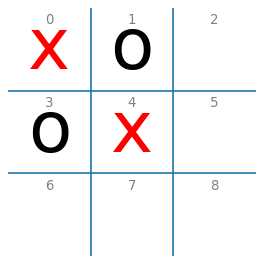


Win or draw:
Number of nodes searched: 22


[2,
 [['if', ['x', 'o', 'x', 'o', 'x', 'o', ' ', ' ', ' '], 'then', [6, 'win']],
  ['if',
   ['x', 'o', 'x', 'o', 'x', ' ', 'o', ' ', ' '],
   'then',
   [5,
    [['if', ['x', 'o', 'x', 'o', 'x', 'x', 'o', 'o', ' '], 'then', [8, 'win']],
     ['if',
      ['x', 'o', 'x', 'o', 'x', 'x', 'o', ' ', 'o'],
      'then',
      [7, 'draw']]]]],
  ['if',
   ['x', 'o', 'x', 'o', 'x', ' ', ' ', 'o', ' '],
   'then',
   [5,
    [['if', ['x', 'o', 'x', 'o', 'x', 'x', 'o', 'o', ' '], 'then', [8, 'win']],
     ['if',
      ['x', 'o', 'x', 'o', 'x', 'x', ' ', 'o', 'o'],
      'then',
      [6, 'win']]]]],
  ['if',
   ['x', 'o', 'x', 'o', 'x', ' ', ' ', ' ', 'o'],
   'then',
   [5,
    [['if',
      ['x', 'o', 'x', 'o', 'x', 'x', 'o', ' ', 'o'],
      'then',
      [7, 'draw']],
     ['if',
      ['x', 'o', 'x', 'o', 'x', 'x', ' ', 'o', 'o'],
      'then',
      [6, 'win']]]]]]]

CPU times: user 22.1 ms, sys: 21.3 ms, total: 43.4 ms
Wall time: 14.3 ms


In [13]:
board = empty_board() 
board[0] = 'x'
board[1] = 'o'
board[3] = 'o'
board[4] = 'x'

print("Board:")
show_board(board)

print()
print("Win or draw:")
%time display(and_or_search(board, player = 'x', draw_is_win = True))

In [14]:
print("Win only:")
%time display(and_or_search(board, player = 'x', draw_is_win = False))

Win only:
Number of nodes searched: 27


[2,
 [['if', ['x', 'o', 'x', 'o', 'x', 'o', ' ', ' ', ' '], 'then', [6, 'win']],
  ['if', ['x', 'o', 'x', 'o', 'x', ' ', 'o', ' ', ' '], 'then', [8, 'win']],
  ['if',
   ['x', 'o', 'x', 'o', 'x', ' ', ' ', 'o', ' '],
   'then',
   [5,
    [['if', ['x', 'o', 'x', 'o', 'x', 'x', 'o', 'o', ' '], 'then', [8, 'win']],
     ['if',
      ['x', 'o', 'x', 'o', 'x', 'x', ' ', 'o', 'o'],
      'then',
      [6, 'win']]]]],
  ['if', ['x', 'o', 'x', 'o', 'x', ' ', ' ', ' ', 'o'], 'then', [6, 'win']]]]

CPU times: user 21.7 ms, sys: 10.9 ms, total: 32.6 ms
Wall time: 10.8 ms


## x can draw_is_win if it chooses 7

Board:


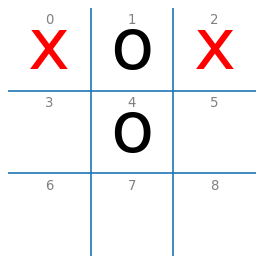


Win or draw:
Number of nodes searched: 56


[7,
 [['if',
   ['x', 'o', 'x', 'o', 'o', ' ', ' ', 'x', ' '],
   'then',
   [5,
    [['if', ['x', 'o', 'x', 'o', 'o', 'x', 'o', 'x', ' '], 'then', [8, 'win']],
     ['if',
      ['x', 'o', 'x', 'o', 'o', 'x', ' ', 'x', 'o'],
      'then',
      [6, 'draw']]]]],
  ['if',
   ['x', 'o', 'x', ' ', 'o', 'o', ' ', 'x', ' '],
   'then',
   [3,
    [['if',
      ['x', 'o', 'x', 'x', 'o', 'o', 'o', 'x', ' '],
      'then',
      [8, 'draw']],
     ['if',
      ['x', 'o', 'x', 'x', 'o', 'o', ' ', 'x', 'o'],
      'then',
      [6, 'win']]]]],
  ['if',
   ['x', 'o', 'x', ' ', 'o', ' ', 'o', 'x', ' '],
   'then',
   [3,
    [['if',
      ['x', 'o', 'x', 'x', 'o', 'o', 'o', 'x', ' '],
      'then',
      [8, 'draw']],
     ['if',
      ['x', 'o', 'x', 'x', 'o', ' ', 'o', 'x', 'o'],
      'then',
      [5, 'draw']]]]],
  ['if',
   ['x', 'o', 'x', ' ', 'o', ' ', ' ', 'x', 'o'],
   'then',
   [3,
    [['if', ['x', 'o', 'x', 'x', 'o', 'o', ' ', 'x', 'o'], 'then', [6, 'win']],
     ['if',
      ['x', '

CPU times: user 16.8 ms, sys: 26.6 ms, total: 43.4 ms
Wall time: 14.5 ms


In [15]:

board = empty_board() 
board[0] = 'x'
board[1] = 'o'
board[2] = 'x'
#board[3] = 'o'
board[4] = 'o'

print("Board:")
show_board(board)

print()
print("Win or draw:")
%time display(and_or_search(board, player = 'x', draw_is_win = True))

In [16]:
print("Win only:")
%time display(and_or_search(board, player = 'x', draw_is_win = False))

Win only:
Number of nodes searched: 52


None

CPU times: user 13.3 ms, sys: 6.51 ms, total: 19.9 ms
Wall time: 6.39 ms


## o is about to win

Board:


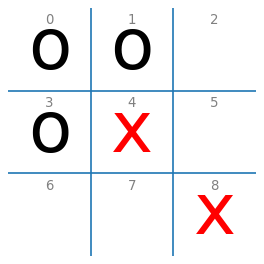


Win or draw:
Number of nodes searched: 7


None

CPU times: user 5.1 ms, sys: 2.65 ms, total: 7.76 ms
Wall time: 2.47 ms


In [17]:
board = empty_board() 
board[0] = 'o'
board[1] = 'o'
board[3] = 'o'
board[4] = 'x'
board[8] = 'x'

print("Board:")
show_board(board)

print()
print("Win or draw:")
%time display(and_or_search(board, player = 'x', draw_is_win = True))

Check for player o

In [18]:
print("Win only:")
%time display(and_or_search(board, player = 'o', draw_is_win = False))

Win only:
Number of nodes searched: 2


[2, 'win']

CPU times: user 9.68 ms, sys: 0 ns, total: 9.68 ms
Wall time: 2.94 ms


## Empty board: Only a draw_is_win can be guaranteed

Board:


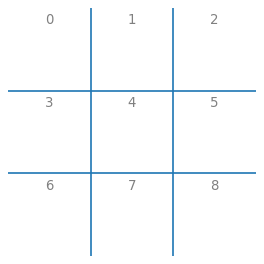


Win or draw:
Number of nodes searched: 833


[0,
 [['if',
   ['x', 'o', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
   'then',
   [2,
    [['if',
      ['x', 'o', 'x', 'o', ' ', ' ', ' ', ' ', ' '],
      'then',
      [4,
       [['if',
         ['x', 'o', 'x', 'o', 'x', 'o', ' ', ' ', ' '],
         'then',
         [6, 'win']],
        ['if',
         ['x', 'o', 'x', 'o', 'x', ' ', 'o', ' ', ' '],
         'then',
         [5,
          [['if',
            ['x', 'o', 'x', 'o', 'x', 'x', 'o', 'o', ' '],
            'then',
            [8, 'win']],
           ['if',
            ['x', 'o', 'x', 'o', 'x', 'x', 'o', ' ', 'o'],
            'then',
            [7, 'draw']]]]],
        ['if',
         ['x', 'o', 'x', 'o', 'x', ' ', ' ', 'o', ' '],
         'then',
         [5,
          [['if',
            ['x', 'o', 'x', 'o', 'x', 'x', 'o', 'o', ' '],
            'then',
            [8, 'win']],
           ['if',
            ['x', 'o', 'x', 'o', 'x', 'x', ' ', 'o', 'o'],
            'then',
            [6, 'win']]]]],
        ['if',
        

CPU times: user 309 ms, sys: 115 ms, total: 424 ms
Wall time: 186 ms


In [19]:
board = empty_board() 

print("Board:")
show_board(board)

print()
print("Win or draw:")
%time display(and_or_search(board, player = 'x', draw_is_win = True))

In [20]:
print("Win only:")
%time display(and_or_search(board, player = 'x', draw_is_win = False))

Win only:
Number of nodes searched: 13023


None

CPU times: user 1.02 s, sys: 0 ns, total: 1.02 s
Wall time: 1.02 s


## Experiments


### Baseline: Randomized Player

A completely randomized player agent can be used as a weak baseline.

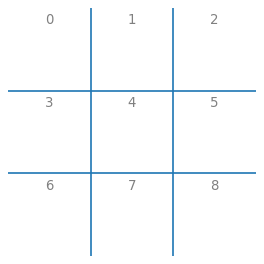

CPU times: user 4.55 ms, sys: 0 ns, total: 4.55 ms
Wall time: 2.2 ms


7

In [21]:
def random_player(board, player = None):
    """Simple player that chooses a random empy square (equal probability of all permissible actions). 
    player is unused."""
    return np.random.choice(actions(board))

show_board(board)
%time random_player(board)

### The Environment

Implement the environment that calls the agent. The percept is the board and the action is move.

In [22]:
def switch_player(player, x, o):
    if player == 'x':
        return 'o', o
    else:
        return 'x', x

def play(x, o, N = 100):
    """Let two agents play each other N times. x starts. x and y are agent functions that 
    get the board as the percept and return their next action."""
    results = {'x': 0, 'o': 0, 'd': 0}
    
    for i in range(N):
        board = empty_board()
        player, fun = 'x', x
        
        while True:
            a = fun(board, player)
            board = result(board, player, a)
            
            win = check_win(board)   # returns the 'n' if the game is not done.
            if win != 'n':
                results[win] += 1
                break
            
            player, fun = switch_player(player, x, o)   
    
    return results

### Random vs. Random

In [23]:
# timeit: n ... how many times to execute the statement, 
#         r ... how many times to repeat the timer (default 5)

%time display(play(random_player, random_player, N = 100))

{'x': 59, 'o': 26, 'd': 15}

CPU times: user 223 ms, sys: 60.4 ms, total: 283 ms
Wall time: 92.3 ms


_Note:_ It looks like the first player (x) has an advantage!

### And-Or Tree Search vs. Random

Put AND-OR search into a wrapper agent function. Note that if AND-OR search cannot guarantee a win then
it does not return a plan, nut `None`. In this case, we do not know what the best (i.e., the least "bad") 
move is, so I make the agent play randomly. Other methods that we will learn about later can determine the utility of a move, even if it does not guarantee a win.

In [24]:
DEBUG = 0

def and_or_player(board, player = 'x'):
    plan = and_or_search(board, player)

    # if there is no plan then we do a random action
    if plan is None: 
        return np.random.choice(actions(board))
    else:
        return plan[0]



print("and-or-search vs. random:")
%time display(play(and_or_player, random_player))

print()
print("random vs. and-or-search")
%time display(play(random_player, and_or_player))

and-or-search vs. random:


{'x': 93, 'o': 0, 'd': 7}

CPU times: user 6.98 s, sys: 1.35 ms, total: 6.98 s
Wall time: 6.98 s

random vs. and-or-search


{'x': 0, 'o': 72, 'd': 28}

CPU times: user 9.72 s, sys: 1.56 ms, total: 9.72 s
Wall time: 9.72 s


**Note how slow this is!**

My lazy implementation is a _simple reflex agent_ that recreates a conditional plan every time it is asked for an action. ut since And-Or search already produces a complete conditional plan for the empty board, a better implementation would use a _model-based reflex agent_ that store this precomputed plan and just follow it without more planing.

### And-Or Tree Search vs. And-Or Tree Search

In [25]:
# No randomness -> run only once

%time display(play(and_or_player, and_or_player, N = 1))

{'x': 0, 'o': 0, 'd': 1}

CPU times: user 159 ms, sys: 4.32 ms, total: 163 ms
Wall time: 162 ms
